In [ ]:
import xarray as xr
import datetime
import os
from glob import glob
import matplotlib.pyplot as plt
from cmocean import cm
import numpy as np
import cartopy.crs as ccrs
import matplotlib.colors as colors
from matplotlib import axes

os.environ['CARTOPY_USER_BACKGROUNDS'] = '/home/shkifmjr/cartopy_images/'

import warnings
warnings.simplefilter('ignore')

img = plt.imread('/home/shkifmjr/cartopy_images/BlueMarble_TOPO_010_FEB.png')

### Defining path to data

In [2]:
OR10_03_base = '/scratch/usr/shkifmmp/postproc_ORION10/velocities/base/'
OR10_03_nest = '/scratch/usr/shkifmmp/postproc_ORION10/velocities/'

OR10_03_k10 = '/scratch/usr/shkifmmp/postproc_ORION10/velocities/vel_eke_k10/'

FOCI_nest = '/scratch/usr/shkifmmp/ORION10X/'
FOCI_base = '/scratch/usr/shkifmmp/ORION10X/base/'

In [3]:
#mask for nest
mask_path = '/scratch/usr/shklvn09/NUDATA/ORION/10-data/meshmask/1_mesh_mask.nc'
mask =xr.open_dataset(mask_path, chunks={"z":46, "y":100, "x":100})#.tmask.isel(z=0).squeeze()
mask = mask.rename({'z':'deptht'}) #renaming dimension z to deptht

In [ ]:
mask

In [4]:
tmask = mask.tmask.isel(deptht=0).squeeze()

In [5]:
e1t = mask.e1t.squeeze()
e2t = mask.e2t.squeeze()

### Time series

In [6]:
# just once, to check latitude differences from FOCI and ORION10

# nav_lat_nest = xr.open_mfdataset(paths = '/scratch/usr/shkifmmp/postproc_ORION10/velocities/1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP03_1y_20060101_20061231_EKE.nc', 
#                              chunks={"y":100, "x":100}).isel(deptht=9).nav_lat
# nav_lat_nest_foci = xr.open_mfdataset(paths = sorted(glob(FOCI_nest + '1_FOCI*_k10.nc'))[0], 
#                              chunks={"y":100, "x":100}).nav_lat

# lat_foci = nav_lat_nest_foci.isel(x=0)
# lat = nav_lat_nest.isel(x=0)

# nav_lat_nest_foci.isel(y=slice(295,924))[185:625].values
# lat.values[0], lat_foci.values[0], lat.values[-1], lat_foci.values[-1]

# np.where(lat_foci == lat[-1]), np.where(lat_foci == lat[0])

# np.where((lat <= -30) & (lat >=-68)) # 0 - 624 for 1_ORION10
# np.where((lat_foci < -30) & (lat_foci >-68)) 

In [6]:
def weighted_mean(variable, weight, mask):
    variable = variable.where(mask)
    weight = weight.where(mask)
    return (variable * weight).sum(('x','y')) / weight.sum(('x','y'))

In [7]:
area = (e1t * e2t).isel(y=slice(None,625)) #30S to 68S

#### 1_ORION10

In [8]:
OR10_eke_nest_30S_68S = xr.open_mfdataset(paths = sorted(glob(OR10_03_nest + '1_OR*_k10.nc')), 
                                                chunks={"y":100, "x":100}).voeke.where(tmask).isel(y=slice(None,625)).squeeze()

In [18]:
OR10_eke_nest_30S_68S

,Array,Chunk
Bytes,543.51 MB,40.00 kB
Shape,"(61, 625, 3564)","(1, 100, 100)"
Count,77678 Tasks,15372 Chunks
Type,float32,numpy.ndarray


In [11]:
OR10_eke_nest_30S_68S_mean = weighted_mean(OR10_eke_nest_30S_68S, area, tmask.isel(y=slice(None,625))).compute()

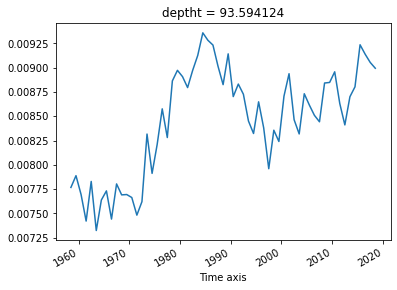

In [12]:
OR10_eke_nest_30S_68S_mean.plot()

#### 1_FOCI 

In [13]:
FOCI_eke_nest = xr.open_mfdataset(paths = sorted(glob(FOCI_nest + '1_FOCI*_k10.nc')), 
                             chunks={"y":100, "x":100}).voeke.isel(y=slice(295,924)).where(tmask)

In [14]:
FOCI_eke_nest_30S = FOCI_eke_nest.isel(y=slice(None,625)).squeeze()

In [15]:
FOCI_eke_nest_30S_mean = weighted_mean(FOCI_eke_nest_30S, area, tmask.isel(y=slice(None,625))).compute()

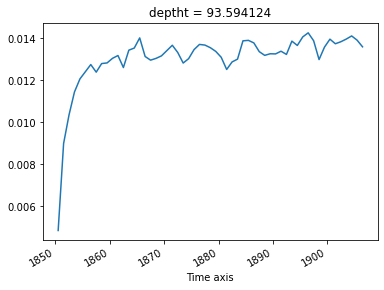

In [16]:
FOCI_eke_nest_30S_mean.plot()

#### plotting

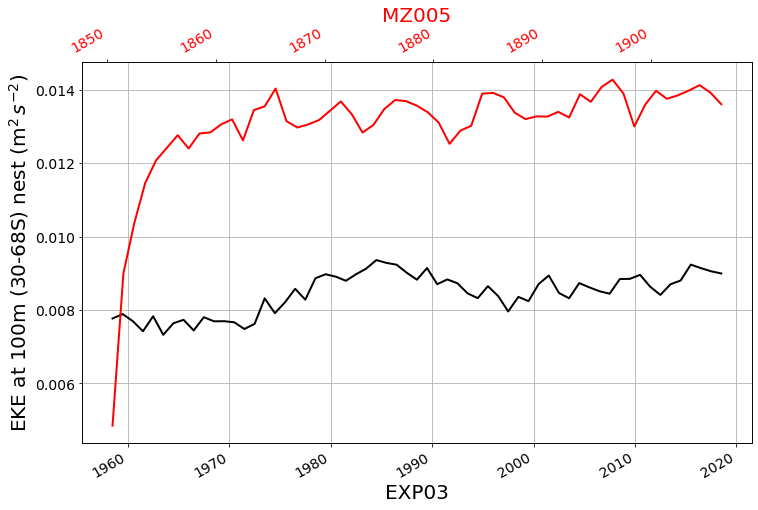

In [19]:
plt.figure(figsize=(12,7))
ax = plt.gca()

ax1= ax.twiny()

OR10_eke_nest_30S_68S_mean.plot(color='black', linewidth=2, label='1_ORION10 EXP03', ax=ax)
FOCI_eke_nest_30S_mean.plot(color='red', linewidth=2, label='1_FOCI', ax=ax1)

ax.set_xlabel('EXP03', fontsize=20)
ax1.set_xlabel('MZ005', fontsize=20, color= 'red')
ax.set_ylabel('EKE at 100m (30-68S) nest (m$^{2}\,s^{-2}$)', fontsize=20)
ax.set_title(None), ax1.set_title(None)
ax1.tick_params(axis= 'x', labelcolor = 'red', labelsize= 14)
ax.tick_params(axis= 'x', labelsize= 14)
ax.tick_params(axis= 'y', labelsize= 14)


ax.grid(axis='both')

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/figures/'
plt.savefig(savepath + 'EKE_timeseries_1FOCI_1ORION10.png', format='png', facecolor="w")

## Maps

### base

In [4]:
# mask
mask_base_p = '/scratch/usr/shklvn09/NUDATA/ORION/10-data/meshmask/mesh_mask.nc'
mask_base =xr.open_dataset(mask_base_p, chunks={"z":46, "y":100, "x":100}).tmask.isel(z=0).squeeze()

In [5]:
eke_OR10_base = xr.open_mfdataset(paths = sorted(glob(OR10_03_base + 'OR*EKE.nc')), 
                             chunks={"y":100, "x":100, "deptht":46}).voeke.isel(deptht=9).squeeze().where(mask_base)

In [6]:
eke_FOCI_base = xr.open_mfdataset(paths = sorted(glob(FOCI_base + 'FOCI*EKE.nc')), 
                                 chunks={"y":100, "x":100, "deptht":46}).voeke.isel(deptht=9).squeeze().where(mask_base)

### nest

In [25]:
# mask for ORION10 -> tmask

# mask for 1_FOCI
mask_nest_foci = '/scratch/usr/shkmazel/masks/ORION10Xnospongeinocean/1_mesh_mask.nc'
mask_nest_f =xr.open_dataset(mask_nest_foci, chunks={"z":46, "y":100, "x":100}).tmask.isel(z=0).squeeze()

In [26]:
eke_OR10_nest = xr.open_mfdataset(paths = sorted(glob(OR10_03_nest + '1_OR*EKE_k10.nc')), 
                                 chunks={"y":100, "x":100}).voeke.squeeze().where(tmask)

In [29]:
eke_FOCI_nest = xr.open_mfdataset(paths = sorted(glob(FOCI_nest + '1_*_k10.nc')), 
                                 chunks={"y":100, "x":100}).voeke.squeeze().where(mask_nest_f)

### Assigning nav_lat and nav_lon as coordinates and correcting discontinuity of grid

### base

In [31]:
# loading data for lat/lon
nav_lat = xr.open_mfdataset(paths = sorted(glob(OR10_03_base + 'OR*EKE.nc'))[0]).nav_lat
nav_lon = xr.open_mfdataset(paths = sorted(glob(OR10_03_base + 'OR*EKE.nc'))[0]).nav_lon

In [32]:
eke_OR10_base = eke_OR10_base.assign_coords(nav_lat= nav_lat, nav_lon=nav_lon)

In [ ]:
eke_FOCI_base

In [33]:
eke_OR10_base.coords["x"] = range(len(eke_OR10_base.x))
eke_OR10_base.coords["y"] = range(len(eke_OR10_base.y))

In [34]:
after_discont = ~(eke_OR10_base.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)

In [35]:
eke_OR10_base.coords["nav_lon"] = (
    eke_OR10_base.coords["nav_lon"]
    + 360 * after_discont
)

In [36]:
eke_FOCI_base = eke_FOCI_base.assign_coords(nav_lat = eke_OR10_base.coords["nav_lat"], nav_lon = eke_OR10_base.coords["nav_lon"])

In [37]:
eke_OR10_base = eke_OR10_base.isel(x=slice(1, -1), y=slice(None, -1))
eke_FOCI_base = eke_FOCI_base.isel(x=slice(1, -1), y=slice(None, -1))

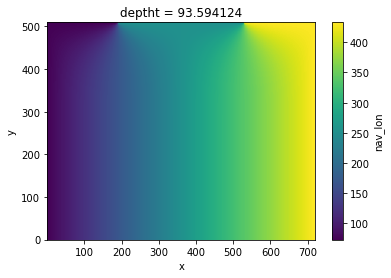

In [39]:
eke_FOCI_base.coords['nav_lon'].plot()

In [40]:
mean_OR10 = eke_OR10_base.mean(dim='time_counter').compute()
mean_FOCI = eke_FOCI_base.mean(dim='time_counter').compute()

In [41]:
mean_FOCI.min().values, mean_FOCI.max().values, mean_OR10.min().values, mean_OR10.max().values

(array(1.3129437e-17, dtype=float32),
 array(0.47179556, dtype=float32),
 array(5.4677054e-07, dtype=float32),
 array(0.39944848, dtype=float32))

### nest

In [43]:
# ORION10
nav_lat_1 = xr.open_mfdataset(paths = sorted(glob(OR10_03_nest + '1_OR*EKE.nc'))[0]).nav_lat
nav_lon_1 = xr.open_mfdataset(paths = sorted(glob(OR10_03_nest + '1_OR*EKE.nc'))[0]).nav_lon

In [44]:
eke_OR10_nest = eke_OR10_nest.assign_coords(nav_lat= nav_lat_1, nav_lon=nav_lon_1)

In [45]:
eke_OR10_nest.coords["x"] = range(len(eke_OR10_nest.x))
eke_OR10_nest.coords["y"] = range(len(eke_OR10_nest.y))

In [46]:
after_discont_1 = ~(eke_OR10_nest.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)

In [47]:
eke_OR10_nest.coords["nav_lon"] = (
    eke_OR10_nest.coords["nav_lon"]
    + 360 * after_discont_1
)

In [48]:
# FOCI
nav_lat_2 = xr.open_mfdataset(paths = sorted(glob(FOCI_nest + '1_*EKE.nc'))[0]).nav_lat
nav_lon_2 = xr.open_mfdataset(paths = sorted(glob(FOCI_nest + '1_*EKE.nc'))[0]).nav_lon

In [49]:
eke_FOCI_nest = eke_FOCI_nest.assign_coords(nav_lat= nav_lat_2, nav_lon=nav_lon_2)

In [50]:
eke_FOCI_nest.coords["x"] = range(len(eke_FOCI_nest.x))
eke_FOCI_nest.coords["y"] = range(len(eke_FOCI_nest.y))

In [51]:
after_discont_2 = ~(eke_FOCI_nest.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)

In [52]:
eke_FOCI_nest.coords["nav_lon"] = (
    eke_FOCI_nest.coords["nav_lon"]
    + 360 * after_discont_2
)

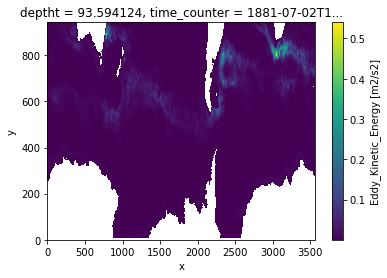

In [91]:
eke_FOCI_nest.isel(time_counter=30).plot()

In [102]:
eke_OR10_nest = eke_OR10_nest.isel(x=slice(1, -1), y=slice(1, -1))
eke_FOCI_nest = eke_FOCI_nest.isel(x=slice(1, None))#, y=slice(None, -1))

In [109]:
mean_OR10_1 = eke_OR10_nest.mean(dim='time_counter').compute()
mean_FOCI_1 = eke_FOCI_nest.mean(dim='time_counter').compute()

In [ ]:
mean_OR10_1

#### Plotting

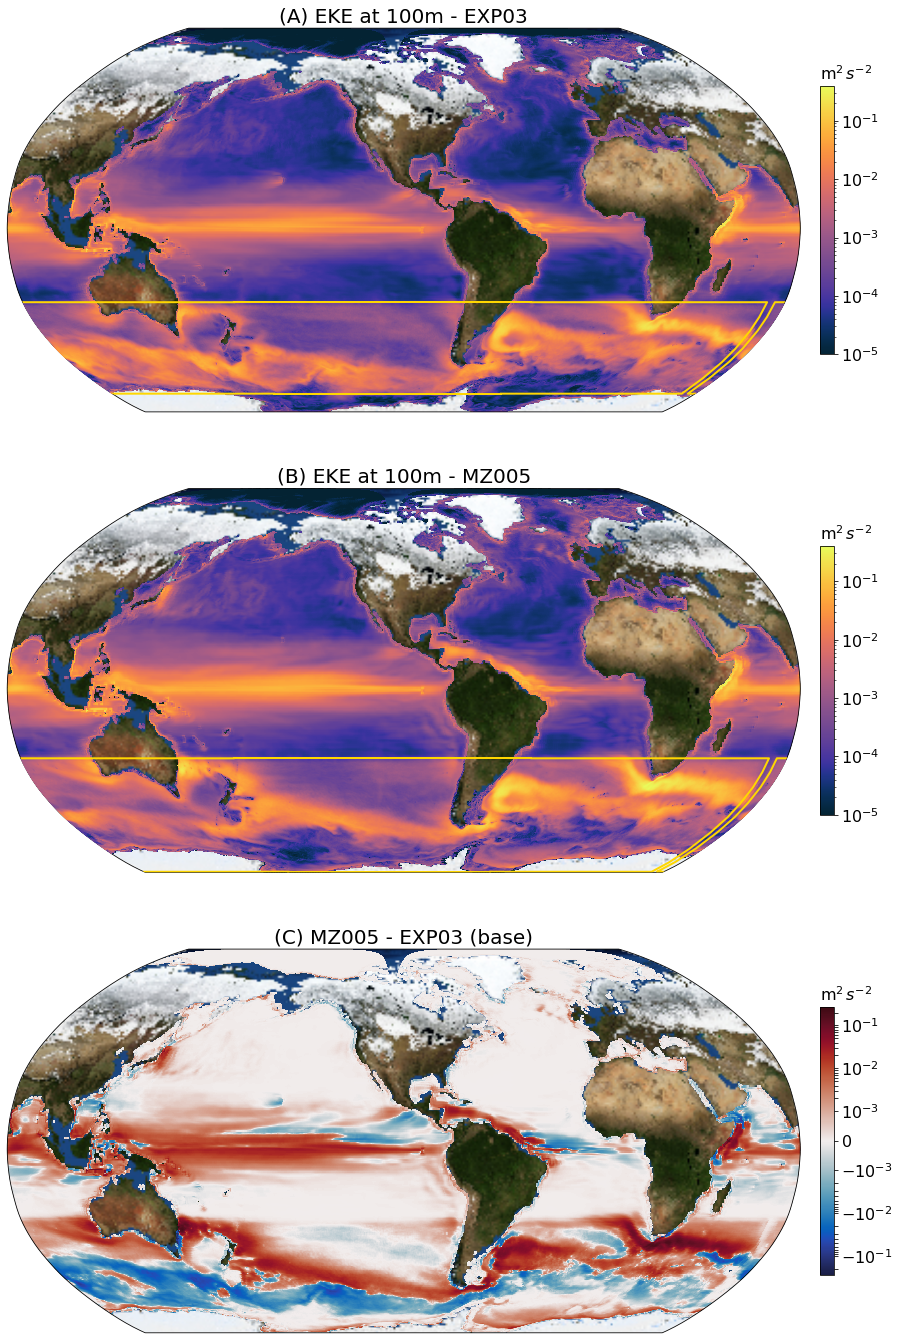

In [120]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(18,24), subplot_kw={'projection': ccrs.Robinson(central_longitude = -100)}, facecolor="none")

map1 = mean_OR10.isel(y=slice(None,-7)).plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), ax=axs[0], add_colorbar= False,
                                           norm=colors.LogNorm(vmin=1e-5, vmax=0.39944848),
                                           cmap=cm.thermal, zorder=2)

map2 = mean_OR10_1.isel(y=slice(None,-7)).plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), ax=axs[0], add_colorbar= False,
                                           norm=colors.LogNorm(vmin=1e-5, vmax=0.39944848),
                                           cmap=cm.thermal, zorder=5)

line1 = axs[0].plot([180, nav_lon_1[-1, 0], nav_lon_1[0, 0], 180],
                    [nav_lat_1[-1, 0], nav_lat_1[-1, 0], nav_lat_1[0, 0], nav_lat_1[0, 0]],
                    linewidth=2, color='gold', transform=ccrs.PlateCarree(), zorder=7)
line2 = axs[0].plot([-180, -40],
                    [nav_lat_1[-1, 0], nav_lat_1[-1, 0]],
                    linewidth=2, color='gold', transform=ccrs.PlateCarree(), zorder=7)
line3 = axs[0].plot([-180, -40],
                    [nav_lat_1[0, 0], nav_lat_1[0, 0]],
                    linewidth=2, color='gold', transform=ccrs.PlateCarree(), zorder=7)
line4 = axs[0].plot([-40, nav_lon_1[-1, -1], nav_lon_1[0, -1], -40],
                    [nav_lat_1[-1, -1], nav_lat_1[-1, -1], nav_lat_1[0, -1], nav_lat_1[0, -1]],
                    linewidth=2, color='gold', transform=ccrs.PlateCarree(), zorder=7)


map3 = mean_FOCI.isel(y=slice(None,-7)).plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), ax=axs[1], add_colorbar= False,
                                               norm=colors.LogNorm(vmin=1e-5, vmax=0.39944848),
                                               cmap=cm.thermal, zorder=2)

map4 = mean_FOCI_1.isel(y=slice(None,-7)).plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), ax=axs[1], add_colorbar= False,
                       norm=colors.LogNorm(vmin=1e-5, vmax=0.39944848),
                       cmap=cm.thermal, zorder=5)

line1 = axs[1].plot([180, nav_lon_2[-1, 0], nav_lon_2[0, 0], 180],
                    [nav_lat_2[-1, 0], nav_lat_2[-1, 0], nav_lat_2[0, 0], nav_lat_2[0, 0]],
                    linewidth=2, color='gold', transform=ccrs.PlateCarree(), zorder=7)
line2 = axs[1].plot([-180, -40],
                    [nav_lat_2[-1, 0], nav_lat_2[-1, 0]],
                    linewidth=2, color='gold', transform=ccrs.PlateCarree(), zorder=7)
line3 = axs[1].plot([-180, -40],
                    [nav_lat_2[0, 0], nav_lat_2[0, 0]],
                    linewidth=2, color='gold', transform=ccrs.PlateCarree(), zorder=7)
line4 = axs[1].plot([-40, nav_lon_2[-1, -1], nav_lon_2[0, -1], -40],
                    [nav_lat_2[-1, -1], nav_lat_2[-1, -1], nav_lat_2[0, -1], nav_lat_2[0, -1]],
                    linewidth=2, color='gold', transform=ccrs.PlateCarree(), zorder=7)

map5 = (mean_FOCI - mean_OR10).isel(y=slice(None,-7)).plot(x='nav_lon', y='nav_lat', transform=ccrs.PlateCarree(), ax=axs[2], add_colorbar= False,
                                                            #norm=colors.TwoSlopeNorm(vcenter=0, vmin=-0.15, vmax=0.15),
                                                            #vmax = 0.02,
                                                            #vmin= -0.02,
                                                            norm=colors.SymLogNorm(linthresh=1e-3),#, vmin=-0.02, vmax=0.02),
                                                            cmap=cm.balance)

for ax, maps in zip(axs, [map1, map3, map5]):
            c = plt.colorbar(maps, pad=0.02, shrink=0.7, ax=ax)
            c.ax.set_title('m$^{2}\,s^{-2}$', loc='left', fontsize=16)
            c.ax.tick_params(labelsize=16)
            axes.Axes.tick_params(ax, axis='both' ,labelsize=16)
            ax.imshow(img, origin='upper', transform=ccrs.PlateCarree(), interpolation='bilinear', regrid_shape=200, zorder=0)

            
axs[0].set_title('(A) EKE at 100m - EXP03', fontsize=20)
axs[1].set_title('(B) EKE at 100m - MZ005', fontsize=20)
axs[2].set_title('(C) MZ005 - EXP03 (base)', fontsize=20)

plt.tight_layout()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/figures/'
plt.savefig(savepath + 'EKEmaps_MZ005_EXP03_log.png', format='png', facecolor="w")